In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [25]:
# load in excel sheets
xls = pd.ExcelFile('Basketball_dataset_clean_seth.xlsx')
final_records = pd.read_excel(xls, 0)
game_records = pd.read_excel(xls, list(range(1,69)))

In [26]:
# operations on each team
for i in range(1,69):
    game_records[i]['Team'] = final_records['Team'][i-1]
    game_records[i]['Team'] = game_records[i]['Team'].str.strip()
    game_records[i]['Opponent'] = game_records[i]['Opponent'].str.replace(r'\(\d+\)', '', regex=True)
    game_records[i]['Opponent'] = game_records[i]['Opponent'].str.strip()
    game_records[i]['Score_diff'] = game_records[i]['Tm'] - game_records[i]['Opp']
    game_records[i]['Score_diff_norm'] = game_records[i]['Score_diff'] / (game_records[i]['Tm'] + game_records[i]['Opp']) 
    game_records[i]['Score_diff_ratio'] = game_records[i]['Tm'] / game_records[i]['Opp']
    game_records[i]['Score_diff_ratio'] = np.where(game_records[i]['Score_diff_ratio'] > 1, game_records[i]['Score_diff_ratio'], np.reciprocal(game_records[i]['Score_diff_ratio']) )
    game_records[i]['Elo_diff'] = np.NaN
    game_records[i]['IsUpset'] = False


In [27]:
print(game_records[13])

     G             Date    Type          Opponent W/L   Tm  Opp  Team  \
0    1   Mon Nov 6 2023     REG         Dartmouth   W   92   54  Duke   
1    2  Fri Nov 10 2023     REG           Arizona   L   73   78  Duke   
2    3  Tue Nov 14 2023     REG      Michigan St.   W   74   65  Duke   
3    4  Fri Nov 17 2023     REG          Bucknell   W   90   60  Duke   
4    5  Tue Nov 21 2023     REG          La Salle   W   95   66  Duke   
5    6  Fri Nov 24 2023     REG  Southern Indiana   W   80   62  Duke   
6    7  Wed Nov 29 2023     REG          Arkansas   L   75   80  Duke   
7    8   Sat Dec 2 2023     REG      Georgia Tech   L   68   72  Duke   
8    9   Sat Dec 9 2023     REG         Charlotte   W   80   56  Duke   
9   10  Tue Dec 12 2023     REG           Hofstra   W   89   68  Duke   
10  11  Wed Dec 20 2023     REG            Baylor   W   78   70  Duke   
11  12  Sat Dec 30 2023     REG       Queens (NC)   W  106   69  Duke   
12  13   Tue Jan 2 2024     REG          Syracuse  

In [28]:
# Split the 'Record' column into 'Wins' and 'Losses'
final_records[['Wins', 'Losses']] = final_records['Record'].str.split('-', expand=True).astype(int)

# calculate final_records stats
#final_records["Score_diff"] = np.NaN
#final_records["Score_diff_norm"] = np.NaN
#for i in range(1,69):    
#    final_records["Score_diff"][i-1] = np.sum(game_records[i]['Score_diff'])
#    final_records["Score_diff_norm"][i-1] = np.sum(game_records[i]['Score_diff_norm'])

In [29]:
print(final_records)

    Seed            Team Record  Wins  Losses
0      1           UConn   31-3    31       3
1      2         Houston   30-4    30       4
2      3          Purdue   29-4    29       4
3      4  North Carolina   27-7    27       7
4      5       Tennessee   24-8    24       8
..   ...             ...    ...   ...     ...
63    64         Stetson  22-12    22      12
64    65     Montana St.  17-17    17      17
65    66       Grambling  20-14    20      14
66    67          Howard  18-16    18      16
67    68          Wagner  16-15    16      15

[68 rows x 5 columns]


In [30]:
#
#plt.plot(final_records["Seed"],final_records["Score_diff"])
#plt.plot(final_records["Seed"],150*final_records["Score_diff_norm"])
#plt.xlabel("Team Playoff Seed")
#plt.ylabel("Team Season Score differential")
#plt.title("Playoff Seed vs Score differential")

In [31]:

#plt.plot(final_records["Seed"],final_records["Score_diff_norm"])
#plt.xlabel("Team Playoff Seed")
#plt.ylabel("Team Season Score differential")
#plt.title("Playoff Seed vs Score differential")

In [32]:
# Define the structure of the NumPy array
dtype = [('Team', 'U50'), ('Elo', 'f8')]

# Create an empty NumPy array with the defined structure
elo_table = np.empty(0, dtype=dtype)
print(elo_table)

[]


In [33]:
current_table = game_records[1]
team_name = final_records['Team'][1]
print(team_name)
print(team_name in final_records['Team'][1])
print(final_records['Team'])

Houston
True
0              UConn
1            Houston
2             Purdue
3     North Carolina
4          Tennessee
           ...      
63           Stetson
64       Montana St.
65         Grambling
66            Howard
67            Wagner
Name: Team, Length: 68, dtype: object


In [34]:
c = 400 # some parameter (cannonical value?)
K = 20
start_elo = 1500
for game in range (0,31): #should be 31 games but #19 wisconsin has incomplete data
    for team in range (1,68): #68
        # grab game row
        current_table = game_records[team]
        # debug print statements
        # print(team)
        # print(game)
        # print(current_table)
        team_name = final_records['Team'][team]
        team_elo = start_elo
        team_in_tourney = team_name in final_records['Team'][1]
        opponent_name = current_table["Opponent"][game]
        opponent_elo = start_elo
        opponent_in_tourney = (opponent_name in final_records['Team'][1])
        
        # read opp elo
        if (opponent_name in elo_table['Team']):
            opponent_elo = elo_table[elo_table['Team'] == opponent_name]['Elo'][0]
        else:
            elo_table = np.append(elo_table, np.array([(opponent_name,start_elo)], dtype=dtype))
        # read team elo
        if (team_name in elo_table['Team']):
            team_elo = elo_table[elo_table['Team'] == team_name]['Elo'][0]
        else:
            elo_table = np.append(elo_table, np.array([(team_name,start_elo)], dtype=dtype))
        
        # update team elo --------------
        E = 1/(1+10**((opponent_elo - team_elo)/c)) # expected chance of win
        ratio = current_table['Score_diff_ratio'][game]    
        
        # handle edge case 
        if(current_table['W/L'][game] == 'T'):
            continue
        if(current_table['W/L'][game] == 'W'):
            O = 1
        else:
            O = 0 
        
        team_elo = team_elo + K*ratio * (O - E)

        # Find the index of the team in the Elo table
        index = np.where(elo_table['Team'] == team_name)[0][0]
        # Update the Elo rating
        elo_table[index] = (team_name, team_elo) 

        # update opponent elo ------------- 
        E = 1/(1+10**((team_elo - opponent_elo)/c)) # expected chance of win
        O = abs(O - 1)   
        opponent_elo = opponent_elo + K*ratio * (O - E)
        
        # Find the index of the team in the Elo table
        index = np.where(elo_table['Team'] == opponent_name)[0][0]
        # Update the Elo rating
        elo_table[index] = (opponent_name, opponent_elo) 

print(elo_table)

[('Northern Arizona', 1461.50598194) ('Houston', 1762.0358712 )
 ('Louisiana-Monroe', 1467.57224523) ('Purdue', 1785.93270829)
 ('Samford', 1611.7950988 ) ('North Carolina', 1743.90907806)
 ('Radford', 1496.04664172) ('Tennessee', 1694.07017818)
 ('Tennessee Tech', 1465.72927349) ('Arizona', 1706.08120409)
 ('Morgan State', 1438.59363274) ('Marquette', 1635.26733112)
 ('Northern Illinois', 1457.84921269) ('Iowa St.', 1619.23604838)
 ('Green Bay', 1494.39110339) ('Baylor', 1655.5176772 )
 ('Auburn', 1601.70515211) ('Creighton', 1637.67494365)
 ('Florida A&M', 1408.96831055) ('Kentucky', 1652.04879123)
 ('New Mexico State', 1457.74551777) ('Illinois', 1651.93746443)
 ('Eastern Illinois', 1450.15873074) ('Duke', 1659.68767214)
 ('Dartmouth', 1454.28512577) ('Kansas', 1653.42748872)
 ('North Carolina Central', 1478.02068252) ('Alabama', 1645.27976497)
 ('Morehead St.', 1570.48405855) ('BYU', 1627.80603253)
 ('Houston Christian', 1435.05329147) ('San Diego St.', 1606.88300018)
 ('Cal State 

In [35]:
all_games = pd.concat(game_records.values(), ignore_index=True)
print(all_games)

       G                 Date    Type                  Opponent W/L   Tm  Opp  \
0      1  2023-11-06 00:00:00     REG          Northern Arizona   W   95   52   
1      2  2023-11-11 00:00:00     REG                 Stonehill   W  107   67   
2      3  2023-11-14 00:00:00     REG  Mississippi Valley State   W   87   53   
3      4  2023-11-19 00:00:00     REG                   Indiana   W   77   57   
4      5  2023-11-20 00:00:00     REG                     Texas   W   81   71   
...   ..                  ...     ...                       ...  ..  ...  ...   
2392  29  2024-03-06 00:00:00  CTOURN              Sacred Heart   W   60   57   
2393  30  2024-03-09 00:00:00  CTOURN       Central UConn State   W   66   56   
2394  31  2024-03-12 00:00:00  CTOURN                 Merrimack   W   54   47   
2395  32  2024-03-19 00:00:00    NCAA                    Howard   W   71   68   
2396  33  2024-03-21 00:00:00    NCAA            North Carolina   L   62   90   

        Team  Score_diff  S

In [42]:
count = 0
print(all_games.shape[0])
for game in range(all_games.shape[0]):
    team_name = all_games['Team'][game]
    team_elo = start_elo
    opponent_name = all_games["Opponent"][game]
    opponent_elo = start_elo
    # read opp elo
    if (opponent_name in elo_table['Team']):
        opponent_elo = elo_table[elo_table['Team'] == opponent_name]['Elo'][0]
    #else:
        #print(opponent_name) # Elo not found
    # read team elo
    if (team_name in elo_table['Team']):
        team_elo = elo_table[elo_table['Team'] == team_name]['Elo'][0]
    #else:
        #print(team_name) # Elo not found
    
    elo_diff = team_elo - opponent_elo
    all_games['Elo_diff'][game] = abs(elo_diff)
    all_games['IsUpset'][game] = False
    if (elo_diff >= 0 and all_games['W/L'][game] == 'L'):
        all_games['IsUpset'][game] = True
        count = count + 1 

    if (all_games['Elo_diff'][game] > 10000):
        print(team_name)
        print(opponent_name)
        print(team_elo)
        print(opponent_elo)
print(all_games['Elo_diff']) 
print(count)   

2397
0       104.100484
1        93.119187
2       129.117785
3       101.063198
4        26.459309
           ...    
2392      1.987680
2393      1.987680
2394     36.503634
2395     13.513240
2396    241.921398
Name: Elo_diff, Length: 2397, dtype: float64
476


C:\Users\jake3\AppData\Local\Temp\ipykernel_117964\335654174.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_games['Elo_diff'][game] = abs(elo_diff)
C:\Users\jake3\AppData\Local\Temp\ipykernel_117964\335654174.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_games['IsUpset'][game] = False
C:\Users\jake3\AppData\Local\Temp\ipykernel_117964\335654174.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_games['IsUpset

Text(0.5, 1.0, "Elo Differences During the 23-24 NCAA Men's Basketball Season")

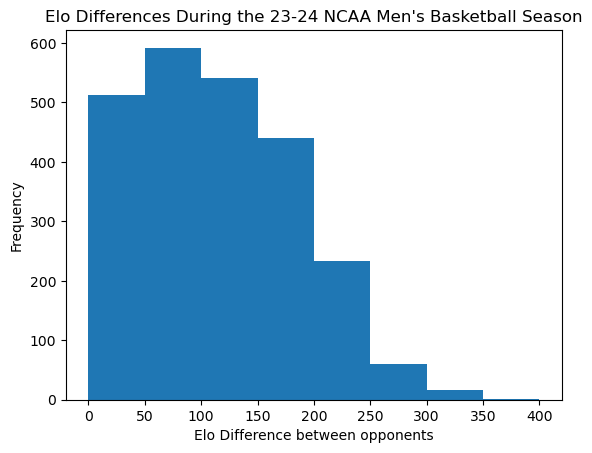

In [37]:
plt.hist(all_games['Elo_diff'], bins=[50*x for x in range(9)])
plt.xlabel('Elo Difference between opponents')
plt.ylabel('Frequency')
plt.title('Elo Differences During the 23-24 NCAA Men\'s Basketball Season')

In [38]:
hist = np.histogram(all_games['Elo_diff'], bins=[50*x for x in range(9)])

In [44]:
upsets = [0,0,0,0,0,0,0,0]
print(hist)
print(np.count_nonzero(hist[1]))
print(all_games.shape[0])
for game in range(all_games.shape[0]):
    elo_diff = all_games['Elo_diff'][game]
    #print(elo_diff)
    #print(all_games['IsUpset'][game])
    if (all_games['IsUpset'][game] == True):
        upsets[int(elo_diff//50)] = upsets[int(elo_diff//50)] + 1

print(upsets)



(array([512, 592, 541, 440, 234,  60,  16,   2], dtype=int64), array([  0,  50, 100, 150, 200, 250, 300, 350, 400]))
8
2397
[153, 142, 109, 49, 20, 3, 0, 0]


In [46]:
upset_ratios = upsets / hist[0]
print(upset_ratios)

[0.29882812 0.23986486 0.20147874 0.11136364 0.08547009 0.05
 0.         0.        ]
